# Solution 1:

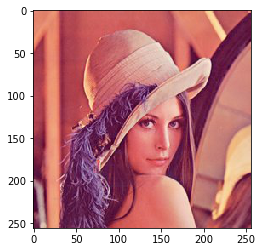

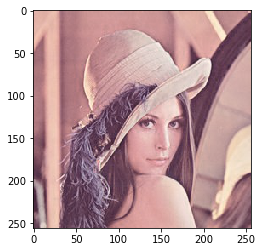

In [3]:
#Importing all libraries
import os
#os.chdir("/home/rohan/Documents/praggu/Visual Computation")
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import colorsys

#Defining function to plot image
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image lena from file. Assuming it is in the same directory.
pil_image = Image.open('lena.jpg')
rgb_image=pil2tensor(pil_image)
hsv_image = pil2tensor(pil_image.convert('HSV'))

#hsv_image = rgb_image.convert('HSV')
hsv_image_sat_new = hsv_image.clone()

# Multiply all elements in the saturation channel image by 0.5. 
#We also denormalise the hue by multiplying it by 360.
hsv_image_sat_new[1]=hsv_image_sat_new[1].mul(0.5)
#hsv_image_sat_new[0]=hsv_image_sat_new[0].mul(360)

#Cloning rgb image to store new image converted from hsv to rgb
#note that .convert('RGB') is not supported by pillow. Hence we will have to write out own way to convert to RGB
rgb_image_sat_new = rgb_image.clone()
for i in range(0,256):
    for j in range(0,256):
        rgb_new=colorsys.hsv_to_rgb(hsv_image_sat_new[0][i][j],hsv_image_sat_new[1][i][j],hsv_image_sat_new[2][i][j])
        rgb_image_sat_new[0][i][j]=rgb_new[0]
        rgb_image_sat_new[1][i][j]=rgb_new[1]
        rgb_image_sat_new[2][i][j]=rgb_new[2]
#Plotting Images        
plot_image(rgb_image)
plot_image(rgb_image_sat_new)

# Solution 2:

kernel size= 26*50

Displayed Image Size=600*416

Final_image=577*369

Input image is padded in SingleChannelConvolution function. Hence size of input image before convolution becomes 602*418.
This is treated as input image size now. 

The size of the final image depends on the size of the input image and the kernel. It should be noted that as convolution involves sliding operation,
if there exists insufficient padding at the margins information will be lost.

In this case, there is a padding of 1 pixel around the image. The size width of our convolution kernel is 26 pixels. Hence the right-most 25 pixels of the image will be be represented by a single pixel at right boundary. Similarly, the bottom most 49 (50-1) kernels will be represented by a single pixel at the lower boundary. 

This is the reason that padding of half the kernel width at the sides, and half the kernel height at the top and bottom is recommended.
In size of the output image after a convolution operation can be generalised as:
output_image_height= input_image_height - kernel_height +1
output_image_width= input_image_width - kernel_width +1



# Solution 3:
To perform convolution, I chose the part of the image which had distinct horizontal features to see how the image would change when convolved with this kernel. As expected horizontal components of the image were emphasized in addition to a blurring effect.

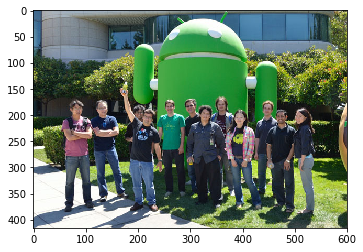

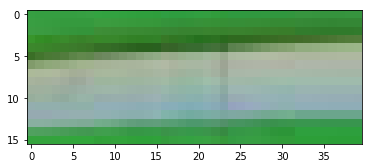

In [5]:
#Single Channel Convolution defined 
def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    from torch.autograd import Variable
    output = F.conv2d(Variable(input_image.unsqueeze(0).unsqueeze(0)), 
                      Variable(kernel.unsqueeze(0).unsqueeze(0)), padding = 1)
    return output.data.squeeze()


#Reading in iimage and converting to tensor. Displaying image.
pil_image = Image.open('google_android.jpg')
rgb_image = pil2tensor(pil_image)
plot_image(rgb_image)

#Selecting convolution kernel
kernel_patch = rgb_image[:, 77:93, 280:320]
#Displaying kernel.
plot_image(kernel_patch)


('output1', torch.Size([1, 403, 563]))
('output2', torch.Size([1, 403, 563]))
('output3', torch.Size([1, 403, 563]))


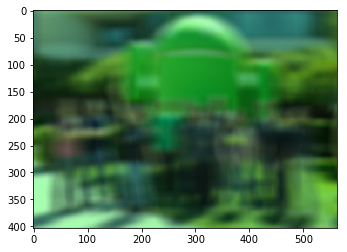

In [36]:
#Performing convolution for each channel
output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)
#normalizing range of values in output image
output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

#displaying output image
plot_image(output_image)

# Solution 4:
we can use convolution to apply some artistic filters to images. As the kernel I've chosen a portion of picaso's work and convolved it with other images to see how it performs on different landscapes. As we can see sharp edges which are a feature of cubism in picasso's work have been introduced into the image.

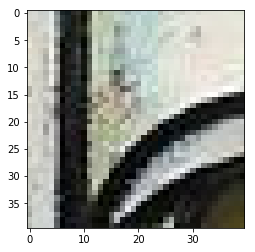

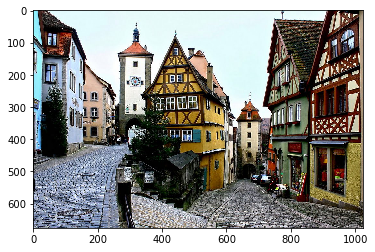

In [11]:
# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open('picaso.jpg')
starry_night = pil2tensor(pil_image)
pil_image = Image.open('town_image.jpg')
town_image = pil2tensor(pil_image)
kernel_patch = starry_night[:, 40:80, 40:80]


plot_image(kernel_patch)
plot_image(town_image)


('output1', torch.Size([1, 639, 987]))
('output2', torch.Size([1, 639, 987]))
('output3', torch.Size([1, 639, 987]))
('output', torch.Size([3, 639, 987]))
('town_image', torch.Size([3, 676, 1024]))


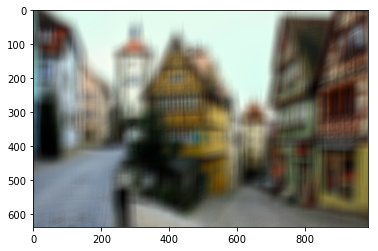

In [12]:
output1 = SingleChannelConvolution(town_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(town_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(town_image[2], kernel_patch[2])
# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('town_image', town_image.size())

plot_image(output_image)

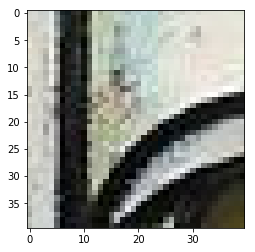

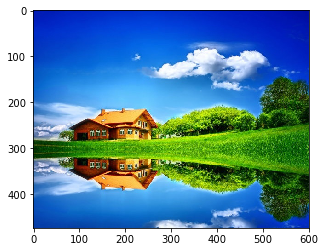

('output1', torch.Size([1, 437, 563]))
('output2', torch.Size([1, 437, 563]))
('output3', torch.Size([1, 437, 563]))
('output', torch.Size([3, 437, 563]))
('town_image', torch.Size([3, 474, 600]))


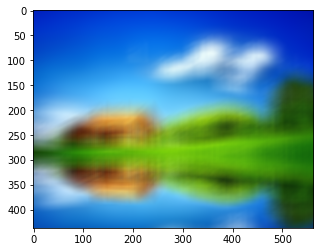

In [13]:
pil_image = Image.open('scenery')
town_image = pil2tensor(pil_image)
kernel_patch = starry_night[:, 40:80, 40:80]


plot_image(kernel_patch)
plot_image(town_image)
output1 = SingleChannelConvolution(town_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(town_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(town_image[2], kernel_patch[2])
# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('town_image', town_image.size())

plot_image(output_image)

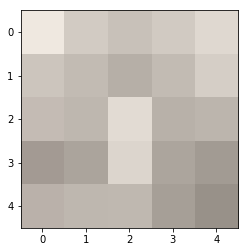

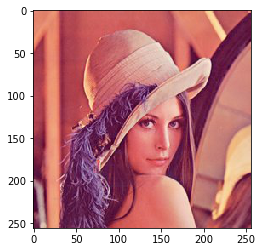

('output1', torch.Size([1, 254, 254]))
('output2', torch.Size([1, 254, 254]))
('output3', torch.Size([1, 254, 254]))
('output', torch.Size([3, 254, 254]))
('town_image', torch.Size([3, 256, 256]))


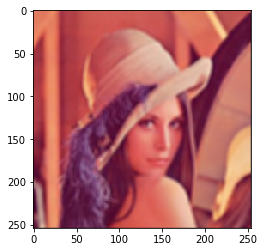

In [10]:
#Repeating with another image
pil_image = Image.open('texture.jpg')
starry_night = pil2tensor(pil_image)
pil_image = Image.open('lena.jpg')
town_image = pil2tensor(pil_image)
kernel_patch = starry_night[:, 10:, 10:30]


plot_image(kernel_patch)
plot_image(town_image)
output1 = SingleChannelConvolution(town_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(town_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(town_image[2], kernel_patch[2])
# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('town_image', town_image.size())

plot_image(output_image)